# [DRAFT] Precomputing near-field volumetric integrals.

## Setting up a test problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

%config InlineBackend.figure_format='retina'

### Lagrange basis functions

In [2]:
N = 7
chebyshev_pts = [sp.cos(sp.pi * i / (N - 1)) for i in range(N)][::-1]
chebyshev_pts_np = np.array([float(p) for p in chebyshev_pts])
x = sp.var("x")

In [3]:
basis_functions = []
for i in range(N):
    xi = chebyshev_pts[i]
    prod = 1
    # The definition of the Lagrange interpolating polynomial.
    # In a numerical context, this definition is troublesome
    # and it's better to use the barycentric Lagrange formulas.
    # But this simple definition works fantastically well in
    # a symbolic setting.
    for j in range(N):
        if j == i:
            continue
        xj = chebyshev_pts[j]
        prod *= (x - xj) / (xi - xj)
    basis_functions.append(prod.simplify().expand())

In [4]:
basis_functions

[8*x**6/3 - 8*x**5/3 - 8*x**4/3 + 8*x**3/3 + x**2/2 - x/2,
 -16*x**6/3 + 8*sqrt(3)*x**5/3 + 20*x**4/3 - 10*sqrt(3)*x**3/3 - 4*x**2/3 + 2*sqrt(3)*x/3,
 16*x**6/3 - 8*x**5/3 - 28*x**4/3 + 14*x**3/3 + 4*x**2 - 2*x,
 -16*x**6/3 + 32*x**4/3 - 19*x**2/3 + 1,
 16*x**6/3 + 8*x**5/3 - 28*x**4/3 - 14*x**3/3 + 4*x**2 + 2*x,
 -16*x**6/3 - 8*sqrt(3)*x**5/3 + 20*x**4/3 + 10*sqrt(3)*x**3/3 - 4*x**2/3 - 2*sqrt(3)*x/3,
 8*x**6/3 + 8*x**5/3 - 8*x**4/3 - 8*x**3/3 + x**2/2 + x/2]

### Precomputing coincident integrals with polar integration

In [5]:
C = 1.0 / (4 * np.pi)


def fundamental_solution(obsx, obsy, srcx, srcy):
    r2 = ((obsx - srcx) ** 2) + ((obsy - srcy) ** 2)
    return C * np.log(r2)

In [6]:
sx, sy = sp.var("sx, sy")

In [7]:
import scipy.integrate


def to_corner(ox, oy, cx, cy):
    t = np.arctan2(cy - oy, cx - ox)
    r = np.sqrt((cx - ox) ** 2 + (cy - oy) ** 2)
    return [t, r]


def compute_coincident(obsx, obsy, basis):
    tol = 1e-16

    def F(srcR, srcT):
        if srcR == 0:
            return 0
        srcx = obsx + np.cos(srcT) * srcR
        srcy = obsy + np.sin(srcT) * srcR
        out = srcR * basis(srcx, srcy) * fundamental_solution(obsx, obsy, srcx, srcy)
        return out

    corner_vecs = [
        to_corner(obsx, obsy, 1, 1),
        to_corner(obsx, obsy, -1, 1),
        to_corner(obsx, obsy, -1, -1),
        to_corner(obsx, obsy, 1, -1),
    ]
    # Normally the theta value for corner idx 2 is negative because it
    # is greater than Pi and the output range of arctan2 is [-pi,pi]
    # But, if the observation point is on the bottom edge of the domain (y=-1)
    # then it's possible for the the theta value to be exactly pi. If this is the
    # case it will be positive and will mess up the integration domains for
    # integrals 2 and 3. So, if it's positive here, we loop around and make
    # it negative.
    if corner_vecs[2][0] > 0:
        corner_vecs[2][0] -= 2 * np.pi

    subdomain = [
        [corner_vecs[0][0], corner_vecs[1][0], lambda t: (1.0 - obsy) / np.sin(t)],
        [
            corner_vecs[1][0],
            corner_vecs[2][0] + 2 * np.pi,
            lambda t: (-1.0 - obsx) / np.cos(t),
        ],
        [corner_vecs[2][0], corner_vecs[3][0], lambda t: (-1.0 - obsy) / np.sin(t)],
        [corner_vecs[3][0], corner_vecs[0][0], lambda t: (1.0 - obsx) / np.cos(t)],
    ]

    Is = []
    for d in subdomain:
        I = scipy.integrate.dblquad(F, d[0], d[1], 0.0, d[2], epsabs=tol, epsrel=tol)
        Is.append(I)

    result = sum([I[0] for I in Is])
    err = sum([I[1] for I in Is])
    return result, err

In [8]:
import pickle

with open("data/constant_test_integral.pkl", "rb") as f:
    coincident, nearfield = pickle.load(f)

ox, oy = sp.symbols("ox, oy")
constant_soln_coincident = sp.lambdify((ox, oy), coincident, "numpy")
constant_soln_nearfield = sp.lambdify((ox, oy), nearfield, "numpy")

In [9]:
%%time
est = compute_coincident(-0.5, -0.5, lambda sx, sy: 1.0)
true = constant_soln_coincident(-0.5, -0.5)
est[0], true, est[0] - true

/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


CPU times: user 1.85 s, sys: 9.47 ms, total: 1.85 s
Wall time: 1.86 s


(-0.11262483019509857, -0.11262483019509859, 1.3877787807814457e-17)

In [10]:
est = compute_coincident(1, 1, lambda sx, sy: 1.0)
true = constant_soln_coincident(1 - 1e-7, 1 - 1e-7)
est[0], true, est[0] - true

(0.20697714190658267, 0.20697706984300004, 7.206358262901169e-08)

In [11]:
est = compute_coincident(0, 1, lambda sx, sy: 1.0)
true = constant_soln_coincident(0, -1 + 1e-7)
est[0], true, est[0] - true

(0.02874576665105402, 0.028745711519333805, 5.5131720213402735e-08)

In [13]:
import multiprocessing


def mp_compute_coincident(obsx, obsy, srci, srcj):
    basis_sxsy = basis_functions[srci].subs(x, sx) * basis_functions[srcj].subs(x, sy)
    basis = sp.lambdify((sx, sy), basis_sxsy, "numpy")
    return compute_coincident(obsx, obsy, basis)


def get_inputs(obs_scale, obs_offsetx, obs_offsety):
    inputs = []
    for obsi in range(N):
        for obsj in range(N):
            obsx = obs_scale * chebyshev_pts_np[obsi] + obs_offsetx
            obsy = obs_scale * chebyshev_pts_np[obsj] + obs_offsety
            for srci in range(N):
                for srcj in range(N):
                    inputs.append((obsx, obsy, srci, srcj))
    return inputs


multiprocessing.set_start_method('fork')
def coincident_grid():
    inputs = get_inputs(1, 0, 0)
    p = multiprocessing.Pool(5)
    return np.array(p.starmap(mp_compute_coincident, inputs))

RuntimeError: context has already been set

In [14]:
%%time
np.save("data/coincident_grid.npy", coincident_grid())

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_14826/846338104.py:44: RuntimeWarning: invalid value encountered in double_scalars
  [corner_vecs[2][0], corner_vecs[3][0], lambda t: (-1.0 - obsy) / np.sin(t)],
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_14826/846338104.py:38: RuntimeWarning: invalid value encountered in double_scalars
  [corner_vecs[0][0], corner_vecs[1][0], lambda t: (1.0 - obsy) / np.sin(t)],


CPU times: user 14.6 ms, sys: 19.8 ms, total: 34.4 ms
Wall time: 9min 44s


In [16]:
# integrals_and_err = compute_grid(1, 0, 0)
integrals_and_err = np.load("data/coincident_grid.npy", allow_pickle=True)
integrals = integrals_and_err[:, 0].reshape((N, N, N, N))
error = integrals_and_err[:, 1].reshape((N, N, N, N))

There are no estimated errors greated than `5e-15`:

In [17]:
np.where(error > 5e-15)[0].shape[0]

0

In [18]:
for i in range(1, N - 1):
    for j in range(1, N - 1):
        err = (
            constant_soln_coincident(chebyshev_pts_np[i], chebyshev_pts_np[j])
            - integrals[i, j, :, :].sum()
        )
        print(err)

5.551115123125783e-17
1.0061396160665481e-16
-9.71445146547012e-17
-7.112366251504909e-17
2.3592239273284576e-16
7.979727989493313e-17
-1.3877787807814457e-17
2.498001805406602e-16
1.6653345369377348e-16
-2.7755575615628914e-17
-3.95516952522712e-16
-2.7755575615628914e-17
5.551115123125783e-17
5.551115123125783e-17
-2.706168622523819e-16
1.8041124150158794e-16
-1.249000902703301e-16
-5.551115123125783e-17
1.8041124150158794e-16
6.591949208711867e-17
-6.938893903907228e-17
1.682681771697503e-16
3.469446951953614e-17
2.949029909160572e-17
-1.3877787807814457e-17


In [19]:
with open("data/xy_test_integral.pkl", "rb") as f:
    coincident, nearfield = pickle.load(f)
xy_soln_coincident = sp.lambdify((ox, oy), coincident, "numpy")
xy_soln_nearfield = sp.lambdify((ox, oy), nearfield, "numpy")
xy_laplacian = lambda x, y: (1 - (1 - x) ** 3) * (1 - (y + 1) ** 2)

In [20]:
cheb2dX, cheb2dY = np.meshgrid(chebyshev_pts_np, chebyshev_pts_np)
cheb2d = np.array([cheb2dX, cheb2dY]).T.reshape((-1, 2)).copy()

In [21]:
f = xy_laplacian(cheb2d[:, 0], cheb2d[:, 1])

for i in range(1, N - 1):
    for j in range(1, N - 1):
        true = xy_soln_coincident(chebyshev_pts_np[i], chebyshev_pts_np[j])
        est = integrals[i, j, :, :].ravel().dot(f.ravel())
        err = true - est
        print(err)

8.881784197001252e-16
2.7755575615628914e-16
5.551115123125783e-17
-1.1102230246251565e-16
-1.1102230246251565e-16
-5.551115123125783e-17
1.1102230246251565e-16
2.7755575615628914e-17
2.220446049250313e-16
1.1102230246251565e-16
1.6653345369377348e-16
-2.7755575615628914e-16
1.0755285551056204e-16
1.6653345369377348e-16
1.3877787807814457e-16
5.551115123125783e-17
-1.3877787807814457e-16
-1.942890293094024e-16
-2.7755575615628914e-17
-1.3877787807814457e-16
-4.440892098500626e-16
-1.6653345369377348e-16
8.326672684688674e-17
-6.38378239159465e-16
-2.220446049250313e-16


## Pre-computing adjacent integrals

In [22]:
def is_on_source_edge(obsx, obsy):
    on_left_right_edges = np.abs(obsx) == 1 and np.abs(obsy) <= 1
    on_top_bottom_edges = np.abs(obsy) == 1 and np.abs(obsx) <= 1
    return on_left_right_edges or on_top_bottom_edges


def compute_nearfield(obsx, obsy, basis):
    if is_on_source_edge(obsx, obsy):
        return compute_coincident(obsx, obsy, basis)

    tol = 1e-16

    def F(srcy, srcx):
        return basis(srcx, srcy) * fundamental_solution(obsx, obsy, srcx, srcy)

    I = scipy.integrate.dblquad(F, -1, 1, -1, 1, epsabs=tol, epsrel=tol)
    return I

In [23]:
est = compute_nearfield(1.1, 1.1, lambda x, y: 1.0)
true = constant_soln_nearfield(1.1, 1.1)
est[0], true, est[0] - true

(0.2729618740920418, 0.2729618740920418, 0.0)

In [24]:
est = compute_nearfield(-1.1, -1.1, xy_laplacian)
true = xy_soln_nearfield(-1.1, -1.1)
est[0], true, est[0] - true

(0.40123407975132336, 0.4012340797513224, 9.43689570931383e-16)

In [25]:
est = compute_nearfield(1.0, 1.0, lambda x, y: 1.0)
true = constant_soln_nearfield(1.0 + 1e-7, 1.0 + 1e-7)
est[0], true, est[0] - true

(0.20697714190658267, 0.20697721397011432, -7.206353164201929e-08)

In [26]:
def mp_compute_nearfield(obsx, obsy, srci, srcj):
    basis_sxsy = basis_functions[srci].subs(x, sx) * basis_functions[srcj].subs(x, sy)
    basis = sp.lambdify((sx, sy), basis_sxsy, "numpy")
    return compute_nearfield(obsx, obsy, basis)


def compute_grid(obs_scale, obs_offsetx, obs_offsety):
    inputs = get_inputs(obs_scale, obs_offsetx, obs_offsety)
    p = multiprocessing.Pool()
    return np.array(p.starmap(mp_compute_nearfield, inputs))

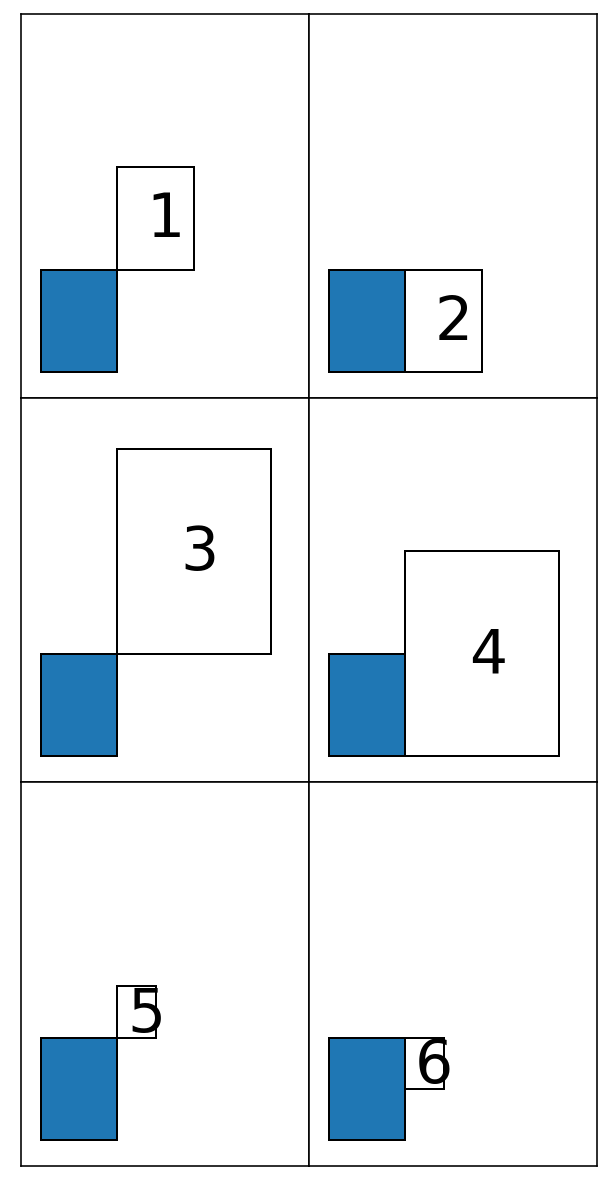

In [29]:
import matplotlib.patches as patches

xrange = [-1.5, 6]
yrange = [-1.5, 6]


def size_and_aspect():
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    # plt.axis("off")
    ax = plt.gca()
    # ax.set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    # plt.axis('equal')


plt.figure(figsize=(4, 8))

plt.subplot(3, 2, 1)
plt.gca().add_patch(patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor="k"))
plt.gca().add_patch(
    patches.Rectangle((1, 1), 2, 2, linewidth=1, edgecolor="k", facecolor="none")
)
plt.text(1.75, 1.65, "1", fontsize=30)
size_and_aspect()

plt.subplot(3, 2, 2)
plt.gca().add_patch(patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor="k"))
plt.gca().add_patch(
    patches.Rectangle((1, -1), 2, 2, linewidth=1, edgecolor="k", facecolor="none")
)
plt.text(1.75, -0.35, "2", fontsize=30)
size_and_aspect()

plt.subplot(3, 2, 3)
plt.gca().add_patch(patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor="k"))
plt.gca().add_patch(
    patches.Rectangle((1, 1), 4, 4, linewidth=1, edgecolor="k", facecolor="none")
)
plt.text(2.65, 2.65, "3", fontsize=30)
size_and_aspect()

plt.subplot(3, 2, 4)
plt.gca().add_patch(patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor="k"))
plt.gca().add_patch(
    patches.Rectangle((1, -1), 4, 4, linewidth=1, edgecolor="k", facecolor="none")
)
plt.text(2.65, 0.65, "4", fontsize=30)
size_and_aspect()


plt.subplot(3, 2, 5)
plt.gca().add_patch(patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor="k"))
plt.gca().add_patch(
    patches.Rectangle((1, 1), 1, 1, linewidth=1, edgecolor="k", facecolor="none")
)
plt.text(1.25, 1.13, "5", fontsize=30)
size_and_aspect()

plt.subplot(3, 2, 6)
plt.gca().add_patch(patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor="k"))
plt.gca().add_patch(
    patches.Rectangle((1, 0), 1, 1, linewidth=1, edgecolor="k", facecolor="none")
)
plt.text(1.25, 0.13, "6", fontsize=30)
size_and_aspect()

plt.show()

In [35]:
%%time
np.save("data/adj1_grid.npy", compute_grid(1, 2, 2))

/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=s

CPU times: user 52.9 ms, sys: 32.5 ms, total: 85.3 ms
Wall time: 50.6 s


In [36]:
%%time
np.save("data/adj2_grid.npy", compute_grid(1, 2, 0))

/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=s

CPU times: user 17.7 ms, sys: 30.3 ms, total: 48 ms
Wall time: 1min 25s


In [37]:
%%time
np.save("data/adj3_grid.npy", compute_grid(2, 3, 3))

/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=s

CPU times: user 15.2 ms, sys: 31.1 ms, total: 46.3 ms
Wall time: 48.1 s


In [38]:
%%time
np.save("data/adj4_grid.npy", compute_grid(2, 3, 1))

/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=s

CPU times: user 16 ms, sys: 30.3 ms, total: 46.3 ms
Wall time: 1min 13s


In [39]:
%%time
np.save("data/adj5_grid.npy", compute_grid(0.5, 1.5, 1.5))

/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=s

CPU times: user 17.8 ms, sys: 30.1 ms, total: 47.9 ms
Wall time: 55.8 s


In [40]:
%%time
np.save("data/adj6_grid.npy", compute_grid(0.5, 1.5, 0.5))

/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=s

CPU times: user 16.8 ms, sys: 30.3 ms, total: 47.1 ms
Wall time: 1min 37s


In [41]:
grid_filenames = [
    "data/coincident_grid.npy",
    "data/adj1_grid.npy",
    "data/adj2_grid.npy",
    "data/adj3_grid.npy",
    "data/adj4_grid.npy",
    "data/adj5_grid.npy",
    "data/adj6_grid.npy",
]
raw_grids = np.array([np.load(g, allow_pickle=True) for g in grid_filenames])

In [42]:
[raw_grids[i].shape for i in range(7)]

[(2401, 2), (2401, 2), (2401, 2), (2401, 2), (2401, 2), (2401, 2), (2401, 2)]

The estimated error is extremely small for all the integrals!

In [43]:
np.where(raw_grids[:, :, 1] > 5e-15)

(array([], dtype=int64), array([], dtype=int64))

In [44]:
all_integrals = raw_grids[:, :, 0].reshape((7, N, N, N ** 2))

## Rotations

In [45]:
def get_test_values(
    soln_fnc, obs_scale, obs_offsetx, obs_offsety, src_center=[0, 0], src_size=[2, 2]
):
    correct = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            obsx = obs_offsetx + obs_scale * chebyshev_pts_np[i]
            obsy = obs_offsety + obs_scale * chebyshev_pts_np[j]
            is_x_edge = np.abs(np.abs(obsx - src_center[0]) - (src_size[0] / 2)) < 1e-8
            is_y_edge = np.abs(np.abs(obsy - src_center[1]) - (src_size[1] / 2)) < 1e-8
            if is_x_edge or is_y_edge:
                correct[i, j] = np.nan
            else:
                correct[i, j] = soln_fnc(obsx, obsy)
    return correct

### Type 1

In [46]:
correct_upper_right = get_test_values(xy_soln_nearfield, 1.0, 2.0, 2.0)
correct_upper_left = get_test_values(xy_soln_nearfield, 1.0, -2.0, 2.0)
correct_lower_left = get_test_values(xy_soln_nearfield, 1.0, -2.0, -2.0)
correct_lower_right = get_test_values(xy_soln_nearfield, 1.0, 2.0, -2.0)

In [47]:
correct_upper_right

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan, 0.20888632, 0.17373242, 0.15911242, 0.16858598,
        0.18298914, 0.18908312],
       [       nan, 0.22559911, 0.20892128, 0.19826569, 0.20269528,
        0.21233289, 0.21673324],
       [       nan, 0.2508107 , 0.24387345, 0.23881498, 0.24135717,
        0.24752993, 0.25050649],
       [       nan, 0.27691704, 0.27327772, 0.2710482 , 0.27327336,
        0.27776208, 0.27993961],
       [       nan, 0.29536519, 0.29276997, 0.2915246 , 0.29364047,
        0.29739278, 0.29919733],
       [       nan, 0.30189447, 0.29954793, 0.29853069, 0.30060083,
        0.30413974, 0.30583523]])

In [48]:
correct_upper_left

array([[        nan,  0.09074064,  0.09204139,  0.10753345,  0.13282085,
         0.15427345,  0.1623824 ],
       [        nan,  0.07131131,  0.07373736,  0.09215686,  0.12068423,
         0.14424874,  0.15304884],
       [        nan,  0.0089379 ,  0.01662526,  0.04651891,  0.0863706 ,
         0.11675999,  0.12770958],
       [        nan, -0.10844552, -0.08249146, -0.02333965,  0.03923725,
         0.08131004,  0.09567511],
       [        nan, -0.28996818, -0.20876109, -0.09342036, -0.00062511,
         0.05392614,  0.07160381],
       [        nan, -0.48574513, -0.30141969, -0.13029595, -0.01754761,
         0.04360349,  0.06286849],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan]])

In [49]:
correct_lower_left

array([[0.36374441, 0.35846448, 0.34283192, 0.31766295, 0.28625841,
        0.25829044,        nan],
       [0.3633949 , 0.35814517, 0.34257328, 0.31729217, 0.28511346,
        0.25572832,        nan],
       [0.36343366, 0.35840148, 0.34348967, 0.31892035, 0.28581558,
        0.2529321 ,        nan],
       [0.36552329, 0.36111733, 0.34845151, 0.32831954, 0.29972128,
        0.2660471 ,        nan],
       [0.36877798, 0.36521734, 0.35594783, 0.34478058, 0.33373555,
        0.31641851,        nan],
       [0.37073844, 0.36767569, 0.36058409, 0.35649664, 0.36650752,
        0.38970031,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan]])

In [50]:
correct_lower_right

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [0.36686762, 0.36143314, 0.34498273, 0.31685687, 0.27773852,
        0.23921819,        nan],
       [0.36952187, 0.36415523, 0.34814038, 0.32211418, 0.29018609,
        0.26450932,        nan],
       [0.37574162, 0.37076171, 0.35629   , 0.33436921, 0.31063682,
        0.29375771,        nan],
       [0.38414986, 0.37969096, 0.3670398 , 0.34884848, 0.33043982,
        0.31781816,        nan],
       [0.39119204, 0.38711798, 0.37571654, 0.35974538, 0.34401081,
        0.33329663,        nan],
       [0.39389428, 0.38995544, 0.37897911, 0.36371941, 0.34878918,
        0.33863212,        nan]])

In [51]:
def nearfield_box(I, Fv, flipx, flipy, rotxy):
    Fv = Fv.reshape((N,N))

    n_rot = {
        (1, 1): 0,
        (1, -1): 1,
        (-1, -1): 2,
        (-1, 1): 3
    }[(flipx, flipy)]
    n_transpose = ((n_rot % 2) == 1) + rotxy

    # Rotate from input coordinates into position
    Fv = np.rot90(Fv, n_rot)
    if n_transpose % 2 == 1:
        Fv = Fv.T

    est = I.dot(Fv.ravel())
    # Reverse the transformation back to the original input space
    if n_transpose % 2 == 1:
        est = est.T
    est = np.rot90(est, -n_rot)
    return est


for C, flipx, flipy in [
    (correct_upper_right, 1, 1),
    (correct_upper_left, -1, 1),
    (correct_lower_left, -1, -1),
    (correct_lower_right, 1, -1),
]:
    Fv = xy_laplacian(cheb2d[:,0], cheb2d[:,1]).reshape((N,N))
    est = nearfield_box(all_integrals[1], Fv, flipx, flipy, 0)
    print(np.max(np.abs((C - est)[~np.isnan(C)])))

3.4638958368304884e-14
3.877453913503359e-14
2.015054789694659e-14
3.858025010572419e-14


### Type 2

In [52]:
correct_middle_right = get_test_values(xy_soln_nearfield, 1.0, 2.0, 0.0)
correct_top_center = get_test_values(xy_soln_nearfield, 1.0, 0.0, 2.0)
correct_middle_left = get_test_values(xy_soln_nearfield, 1.0, -2.0, 0.0)
correct_bottom_center = get_test_values(xy_soln_nearfield, 1.0, 0.0, -2.0)

In [53]:
for C, flipx, flipy, rotxy in [
    (correct_middle_right, 1, 1, 0),
    (correct_top_center, 1, 1, 1),
    (correct_middle_left, -1, 1, 0),
    (correct_bottom_center, 1, -1, 1),
]:
    Fv = xy_laplacian(cheb2d[:,0], cheb2d[:,1])
    est = nearfield_box(all_integrals[2], Fv, flipx, flipy, rotxy)
    print(np.max(np.abs((C - est)[~np.isnan(C)])))

4.884981308350689e-15
4.891920202254596e-15
4.6629367034256575e-15
4.9960036108132044e-15


In [54]:
boxes = {
    # Type 0 (coincident)
    (1, 0, 0): (0, 1, 1, 0),
    # Type 1
    (1, 2, 2): (1, 1, 1, 0),
    (1, -2, 2): (1, -1, 1, 0),
    (1, -2, -2): (1, -1, -1, 0),
    (1, 2, -2): (1, 1, -1, 0),
    # Type 2
    (1, 2, 0): (2, 1, 1, 0),
    (1, 0, 2): (2, 1, 1, 1),
    (1, -2, 0): (2, -1, 1, 0),
    (1, 0, -2): (2, 1, -1, 1),
    # Type 3
    (2, 3, 3): (3, 1, 1, 0),
    (2, -3, 3): (3, -1, 1, 0),
    (2, -3, -3): (3, -1, -1, 0),
    (2, 3, -3): (3, 1, -1, 0),
    # Type 4
    (2, 1, 3): (4, 1, 1, 1),
    (2, -1, 3): (4, -1, 1, 1),
    (2, -3, 1): (4, -1, 1, 0),
    (2, -3, -1): (4, -1, -1, 0),
    (2, -1, -3): (4, -1, -1, 1),
    (2, 1, -3): (4, 1, -1, 1),
    (2, 3, -1): (4, 1, -1, 0),
    (2, 3, 1): (4, 1, 1, 0),
    # Type 5
    (0.5, 1.5, 1.5): (5, 1, 1, 0),
    (0.5, -1.5, 1.5): (5, -1, 1, 0),
    (0.5, -1.5, -1.5): (5, -1, -1, 0),
    (0.5, 1.5, -1.5): (5, 1, -1, 0),
    # Type 6
    (0.5, 0.5, 1.5): (6, 1, 1, 1),
    (0.5, -0.5, 1.5): (6, -1, 1, 1),
    (0.5, -1.5, 0.5): (6, -1, 1, 0),
    (0.5, -1.5, -0.5): (6, -1, -1, 0),
    (0.5, -0.5, -1.5): (6, -1, -1, 1),
    (0.5, 0.5, -1.5): (6, 1, -1, 1),
    (0.5, 1.5, -0.5): (6, 1, -1, 0),
    (0.5, 1.5, 0.5): (6, 1, 1, 0),
}

In [55]:
for box_loc, rot_params in boxes.items():
    soln_fnc = xy_soln_coincident if rot_params[0] == 0 else xy_soln_nearfield
    C = get_test_values(soln_fnc, *box_loc)
    Fv = xy_laplacian(cheb2d[:,0], cheb2d[:,1])
    est = nearfield_box(all_integrals[rot_params[0]], Fv, *rot_params[1:])
    print(np.max(np.abs((C - est)[~np.isnan(C)])))

7.771561172376096e-16
3.4638958368304884e-14
3.877453913503359e-14
2.015054789694659e-14
3.858025010572419e-14
4.884981308350689e-15
4.891920202254596e-15
4.6629367034256575e-15
4.9960036108132044e-15
1.70263803056514e-12
7.013833958069426e-13
5.279110482092619e-13
7.758793607592906e-13
3.019251515468113e-13
2.923217223838037e-13
2.871036741680655e-13
1.3089529460330596e-13
9.764411501578252e-14
8.715250743307479e-14
1.811328864675943e-13
7.527312106958561e-14
5.329070518200751e-15
8.174017018802715e-15
4.496403249731884e-15
3.941291737419306e-15
1.5126788710517758e-15
3.747002708109903e-15
2.886579864025407e-15
3.469446951953614e-15
1.3322676295501878e-15
2.3869795029440866e-15
1.1657341758564144e-15
2.0539125955565396e-15


## Scaling

The remaining piece is to scale the source and observation boxes so that they fit into the rotation scheme above.

In [56]:
def get_test_values(
    soln_fnc, obs_scale, obs_offsetx, obs_offsety, src_center=[0, 0], src_size=2
):
    correct = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            obsx = obs_offsetx + obs_scale * chebyshev_pts_np[i]
            obsy = obs_offsety + obs_scale * chebyshev_pts_np[j]
            is_x_edge = np.abs(np.abs(obsx - src_center[0]) - (src_size / 2)) < 1e-8
            is_y_edge = np.abs(np.abs(obsy - src_center[1]) - (src_size / 2)) < 1e-8
            if is_x_edge or is_y_edge:
                correct[i, j] = np.nan
            else:
                correct[i, j] = soln_fnc(obsx, obsy)
    return correct

In [57]:
with open("data/constant_transformed_test_integral.pkl", "rb") as f:
    constant_soln_shifted = [sp.lambdify((ox, oy), I, "numpy") for I in pickle.load(f)]
with open("data/xy_transformed_test_integral.pkl", "rb") as f:
    xy_soln_shifted = [sp.lambdify((ox, oy), I, "numpy") for I in pickle.load(f)]

In [58]:
basis_integrals = np.empty((N, N))
for srci in range(N):
    for srcj in range(N):
        basis_sxsy = basis_functions[srci].subs(x, sx) * basis_functions[srcj].subs(x, sy)
        basis = sp.lambdify((sx, sy), basis_sxsy, "numpy")
        I = scipy.integrate.dblquad(basis, -1, 1, -1, 1, epsabs=1e-16, epsrel=1e-16)
        basis_integrals[srci, srcj] = I[0]

/Users/tbent/.mambaforge/envs/tectosaur2/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [59]:
def scale_integral(I, basis_dot_F, src_s):
    scale_T = src_s / 2.0
    C = scale_T ** 2
    log_factor = C * (1 / (2 * np.pi)) * np.log(scale_T)
    return C * I + log_factor * basis_dot_F

F_xy = lambda x, y: (1 - x) * (1 - y ** 2)
for i, mult in enumerate([1, 2, 4, 8, 16]):
    src_c = np.array([0, 0])
    src_s = mult / 4.0
    obs_c = np.array([src_c[0] + 0.5 * src_s, src_c[1] - 1.5 * src_s])
    #obs_c = np.array([src_c[0] - 0.5 * src_s, src_c[1] - 1.5 * src_s])

    obs_s = src_s * 2
    transformed_obs_center = np.round(2 * (obs_c - src_c) / src_s, decimals=1)
    transformed_obs_size = np.round(obs_s / src_s, decimals=1)

    correct_xy = get_test_values(
        xy_soln_shifted[i],
        obs_s / 2.0,
        obs_c[0],
        obs_c[1],
        src_center=src_c,
        src_size=src_s,
    )

    src_box_pts = cheb2d * 0.5 * src_s + src_c[None,:]
    Fv_xy = F_xy(src_box_pts[:,0], src_box_pts[:,1])

    nearfield_info = boxes[(transformed_obs_size, *transformed_obs_center)]
    integral_type, flipx, flipy, rotxy = nearfield_info

    basis_I_xy = basis_integrals.ravel().dot(Fv_xy.ravel())

    I_xy = nearfield_box(all_integrals[integral_type], Fv_xy, flipx, flipy, rotxy)

    est_xy = scale_integral(I_xy, basis_I_xy, src_s)

    print(f'\nfor source size={src_s}')
    print("xy error: ", np.max(np.abs(correct_xy - est_xy)[~np.isnan(correct_xy)]))


for source size=0.25
xy error:  2.47198095326695e-17

for source size=0.5
xy error:  1.6132928326584306e-16

for source size=1.0
xy error:  9.43689570931383e-16

for source size=2.0
xy error:  1.099120794378905e-14

for source size=4.0
xy error:  1.1111112030448567e-12


### Computing for an arbitrary box pair.

1. Scale the source box to have width and length 2.
2. Center the source box at `(0,0)`
3. Perform the same transformations on the observation box.
4. Because adjacent boxes are at most one level apart, they will fall into one of the 33 categories defined above.
5. Retrieve the integral type and rotation information and compute the integral!
6. Reverse the rotations.
7. Reverse the scaling via the equations above.

In [72]:
to_save = np.empty(2, object)
to_save[0] = basis_integrals
to_save[1] = all_integrals
np.save("data/nearfield_integrals.npy", to_save) 